# Agglomerative Hierarchical Clustering

## Importing the libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.spatial import distance_matrix as distanceMatrix
from sklearn.preprocessing import OneHotEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

## Functions to load and preprocess the data

In [2]:
def loadData(path):
    data = pd.read_csv(path)
    x = data.iloc[:, :-1].values
    y = data.iloc[:, -1].values
    return x, y

def splitData(x, y, train_size):
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=train_size, random_state=0, stratify=y)
    return x_train, x_test, y_train, y_test

def preprocessData(x):
    
    ct = ColumnTransformer( [('one_hot_encoder', OneHotEncoder(), [1, 2, 3])], remainder='passthrough' )
    ct = ct.fit(x)
    x = pd.DataFrame(ct.transform(x))

    # Scaling the data since the features are in different scales
    scaler = StandardScaler()
    scaler = scaler.fit(x)
    x = pd.DataFrame(scaler.transform(x))

    return x

## The Algorithm

In [3]:
def constructDistanceMatrix(data):
    distance_matrix = distanceMatrix(data, data)
    distance_matrix = (distance_matrix + distance_matrix.T)/2
    np.fill_diagonal(distance_matrix, 0)
    return distance_matrix

def linkage(distance_matrix, clusters, cluster1, cluster2, linkage):
    if linkage == 'single': # Minimum distance between two clusters
        min_distance = np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] < min_distance:
                    min_distance = distance_matrix[i,j]
        return min_distance
    elif linkage == 'complete': # Maximum distance between two clusters
        max_distance = -np.inf
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                if distance_matrix[i,j] > max_distance:
                    max_distance = distance_matrix[i,j]
        return max_distance
    elif linkage == 'average' or linkage == 'mean': # Average distance between two clusters
        sum_distance = 0
        for i in clusters[cluster1]:
            for j in clusters[cluster2]:
                sum_distance += distance_matrix[i,j]
        return sum_distance/(len(clusters[cluster2]) * len(clusters[cluster1]))
    else:
        raise ValueError('Invalid linkage type')
    
def hierarchical_clustering(data, linkage_type, n_clusters, y):
    # Marking each data point as a cluster
    clusters = [[i] for i in range(len(data))]

    # Calculating the distance matrix using Euclidean distance (default of distanceMatrix function)
    distance_matrix = constructDistanceMatrix(data)
    
    # Iteratively merging the clusters
    while len(clusters) > n_clusters:

        # Finding closest two clusters
        min_distance = np.inf
        min_i,min_j = -1,-1
        for i in range(len(clusters)):
            for j in range(i+1,len(clusters)):
                dist = distance_matrix[i,j]
                if dist < min_distance:
                    min_distance = dist
                    min_i,min_j = i,j

        # Merging the closest two clusters
        clusters[min_i] = clusters[min_i] + clusters[min_j]

        # Removing the second cluster
        clusters.pop(min_j)
        
        # Adjusting the distance matrix 
        for i in range(len(clusters)):
            if i == min_i: continue
            distance_matrix[min_i,i] = distance_matrix[i,min_i] = linkage(distance_matrix, clusters, i, min_i, linkage_type)
    
    # Using the majority voting to get the cluster labels 
    indexToLabel = {}
    for i in range(len(clusters)):
        labels = []
        for j in clusters[i]:
            labels.append(y[j])
        indexToLabel[i] = max(set(labels), key=labels.count)
        

    predicted = []
    for i in range(len(data)):
        for j in range(len(clusters)):
            if i in clusters[j]:
                predicted.append(indexToLabel[j])
                break
    return clusters, predicted


## Loading the Raw Data

In [ ]:
# Loading the data
x, y = loadData('archive/kddcup.data.corrected')

## Preprocessing the Data

In [ ]:
# Preprocessing the data
x = preprocessData(x)
print("The shape of the training data is: ", x.shape)

## Splitting the Data into Training and Test Sets

In [ ]:
# Splitting the data into train and test
x_train, x_test, y_train, y_test = splitData(x, y, train_size=0.00025)

## Saving the Data

In [ ]:
# Save the x_train and y_train as numpy arrays
np.save('hierarchicalClustering-Preprocessed/x_train.npy', x_train)
np.save('hierarchicalClustering-Preprocessed/y_train.npy', y_train)

## Loading the Preprocessed Data

In [5]:
# Loading the preprocessed data as numpy arrays
x_train = np.load('Clustering_data-preprocessed/x_train.npy', allow_pickle=True)
y_train = np.load('Clustering_data-preprocessed/y_train.npy', allow_pickle=True)

## Evaluation

In [16]:
# Applying hierarchical clustering
clusters, y_pred = hierarchical_clustering(x_train, 'complete', 512, y_train)

# Evaluating the model
print("Macro: ")
print("Precision: ", precision_score(y_train, y_pred, average='macro'))
print("Recall: ", recall_score(y_train, y_pred, average='macro'))
print("F1 score: ", f1_score(y_train, y_pred, average='macro'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print("Weighted: ")
print("Precision: ", precision_score(y_train, y_pred, average='weighted'))
print("Recall: ", recall_score(y_train, y_pred, average='weighted'))
print("F1 score: ", f1_score(y_train, y_pred, average='weighted'))
print("Accuracy: ", accuracy_score(y_train, y_pred))

print("-" * 50)
print(classification_report(y_train, y_pred))

# Now, let's measure the conditional entropy
totalEntropy = 0
for i in range(len(clusters)):
    clusterEntropy = 0
    counterLabels = {}
    for j in clusters[i]:
        counterLabels[y_train[j]] = counterLabels.get(y_train[j], 0) + 1
    for label in counterLabels:
        clusterEntropy += counterLabels[label]/len(clusters[i]) * np.log2(counterLabels[label]/len(clusters[i]))
    totalEntropy += -clusterEntropy * len(clusters[i])/len(y_train)

print("The average conditional entropy is: ", totalEntropy)

Macro: 
Precision:  0.9065928515641539
Recall:  0.7961704164025888
F1 score:  0.8122272572730201
Accuracy:  0.8954248366013072
--------------------------------------------------
Weighted: 
Precision:  0.908599080440089
Recall:  0.8954248366013072
F1 score:  0.8925075003877859
Accuracy:  0.8954248366013072
--------------------------------------------------
              precision    recall  f1-score   support

    ipsweep.       1.00      0.33      0.50         3
    neptune.       0.99      0.67      0.80       268
       nmap.       1.00      1.00      1.00         1
     normal.       0.76      0.93      0.83       243
  portsweep.       1.00      0.67      0.80         3
      satan.       0.67      1.00      0.80         4
      smurf.       0.93      0.97      0.95       702

    accuracy                           0.90      1224
   macro avg       0.91      0.80      0.81      1224
weighted avg       0.91      0.90      0.89      1224

The average conditional entropy is:  0.210383

## Confusion Matrix

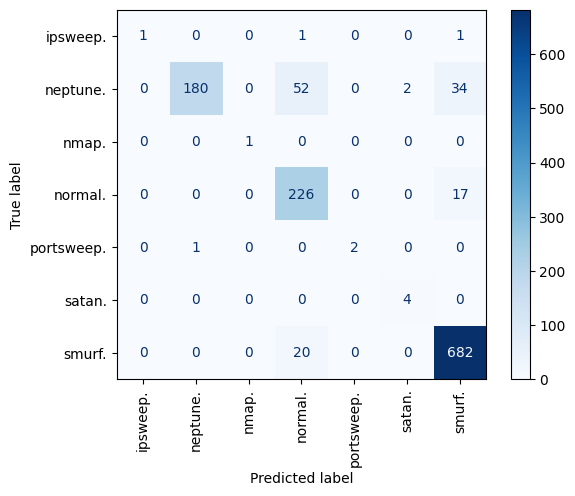

In [17]:
# Printing the confusion matrix
cm = confusion_matrix(y_train, y_pred)
# Displaying the confusion matrix in much bigger size
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_train))
disp.plot(cmap=plt.cm.Blues, values_format='d', xticks_rotation='vertical')
plt.show()